#### Imports

In [39]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [40]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 6, 22, 22, 6, 643662)

#### Connect to Hopsworks Feature Store

In [41]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 


2025-01-06 22:22:06,654 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 22:22:06,665 INFO: Initializing external client
2025-01-06 22:22:06,665 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 22:22:08,211 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207502


#### Feature View Retrieval


In [42]:
feature_view = fs.get_feature_view(
    name='accidents_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [43]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="accident_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [44]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.5784314E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Get Weather Forecast Features with Feature View


In [45]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-01-14 00:00:00+00:00,2.95,0.0,20.523155,271.005066,Stockholm
1,2025-01-12 00:00:00+00:00,-2.45,0.0,15.256526,19.290138,Stockholm
2,2025-01-08 00:00:00+00:00,1.50,0.3,15.517629,183.990829,Stockholm
3,2025-01-15 00:00:00+00:00,2.35,0.0,20.163212,271.023010,Stockholm
4,2025-01-09 00:00:00+00:00,-3.70,0.0,7.072878,284.743622,Stockholm
5,2025-01-10 00:00:00+00:00,-2.10,0.0,17.698677,355.333221,Stockholm
6,2025-01-11 00:00:00+00:00,-3.45,0.0,15.192682,323.673065,Stockholm
7,2025-01-07 00:00:00+00:00,3.05,0.0,24.336637,187.650558,Stockholm
8,2025-01-13 00:00:00+00:00,-7.65,0.0,11.119281,240.945480,Stockholm


#### Making the predictions

In [46]:
batch_data['predicted_accidents'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data.sort_values(by='date', inplace=True)

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_accidents
7,2025-01-07 00:00:00+00:00,3.05,0.0,24.336637,187.650558,Stockholm,13.493452
2,2025-01-08 00:00:00+00:00,1.50,0.3,15.517629,183.990829,Stockholm,14.053751
4,2025-01-09 00:00:00+00:00,-3.70,0.0,7.072878,284.743622,Stockholm,16.053379
5,2025-01-10 00:00:00+00:00,-2.10,0.0,17.698677,355.333221,Stockholm,8.653539
6,2025-01-11 00:00:00+00:00,-3.45,0.0,15.192682,323.673065,Stockholm,9.475287
1,2025-01-12 00:00:00+00:00,-2.45,0.0,15.256526,19.290138,Stockholm,14.067661
8,2025-01-13 00:00:00+00:00,-7.65,0.0,11.119281,240.945480,Stockholm,11.926326
0,2025-01-14 00:00:00+00:00,2.95,0.0,20.523155,271.005066,Stockholm,21.688639
3,2025-01-15 00:00:00+00:00,2.35,0.0,20.163212,271.023010,Stockholm,21.688639


In [47]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 7 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   precipitation_sum            9 non-null      float32                
 3   wind_speed_10m_max           9 non-null      float32                
 4   wind_direction_10m_dominant  9 non-null      float32                
 5   city                         9 non-null      object                 
 6   predicted_accidents          9 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 396.0+ bytes


#### Saving the predictions (for monitoring) to a Feature Group

In [48]:
batch_data['city'] = "Stockholm"
batch_data['country'] = "Sweden"
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_accidents,country,days_before_forecast_day
7,2025-01-07 00:00:00+00:00,3.05,0.0,24.336637,187.650558,Stockholm,13.493452,Sweden,1
2,2025-01-08 00:00:00+00:00,1.50,0.3,15.517629,183.990829,Stockholm,14.053751,Sweden,2
4,2025-01-09 00:00:00+00:00,-3.70,0.0,7.072878,284.743622,Stockholm,16.053379,Sweden,3
5,2025-01-10 00:00:00+00:00,-2.10,0.0,17.698677,355.333221,Stockholm,8.653539,Sweden,4
6,2025-01-11 00:00:00+00:00,-3.45,0.0,15.192682,323.673065,Stockholm,9.475287,Sweden,5
1,2025-01-12 00:00:00+00:00,-2.45,0.0,15.256526,19.290138,Stockholm,14.067661,Sweden,6
8,2025-01-13 00:00:00+00:00,-7.65,0.0,11.119281,240.945480,Stockholm,11.926326,Sweden,7
0,2025-01-14 00:00:00+00:00,2.95,0.0,20.523155,271.005066,Stockholm,21.688639,Sweden,8
3,2025-01-15 00:00:00+00:00,2.35,0.0,20.163212,271.023010,Stockholm,21.688639,Sweden,9


In [49]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 7 to 3
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   precipitation_sum            9 non-null      float32                
 3   wind_speed_10m_max           9 non-null      float32                
 4   wind_direction_10m_dominant  9 non-null      float32                
 5   city                         9 non-null      object                 
 6   predicted_accidents          9 non-null      float32                
 7   country                      9 non-null      object                 
 8   days_before_forecast_day     9 non-null      int64                  
dtypes: datetime64[us, Etc/UTC](1), float32(5), int64(1), object(2)
memory usage: 540.0+ by

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

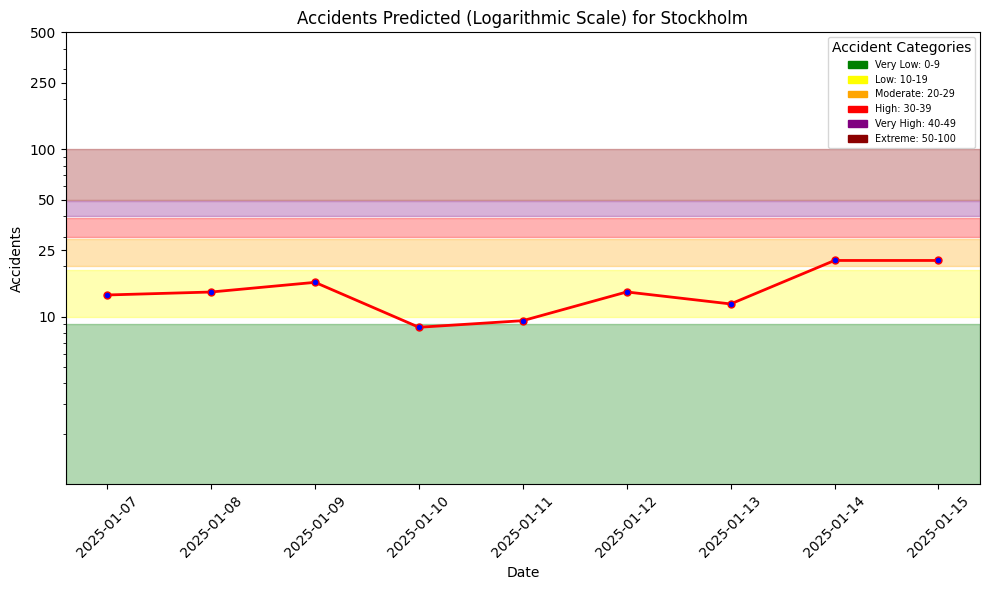

In [50]:
import os
from functions import util
file_path = "../../data/forecast.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_forecast("Stockholm", batch_data, file_path=file_path)
plt.show()

In [51]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='accidents_predictions',
    description='Accidents prediction monitoring',
    version=1,
    primary_key=['city','date','days_before_forecast_day'],
    event_time="date"
)

In [52]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 9/9 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: accidents_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207502/jobs/named/accidents_predictions_1_offline_fg_materialization/executions
2025-01-06 22:22:34,762 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-06 22:22:37,962 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-06 22:23:59,996 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-06 22:24:00,462 INFO: Waiting for log aggregation to finish.
2025-01-06 22:24:09,392 INFO: Execution finished successfully.


(Job('accidents_predictions_1_offline_fg_materialization', 'SPARK'), None)